In [83]:
import pickle
import skfda
import pandas as pd
from neuralprophet import NeuralProphet
from matplotlib import pyplot as plt
import datetime
import numpy as np

# Andiamo a carcare il pickle salvato delle serie su ndvi

Data set:    [[[-0.06657371]
  [-0.04981095]
  [-0.03310659]
  ...
  [ 0.30050689]
  [ 0.29790122]
  [ 0.29532761]]

 [[-0.06859129]
  [-0.05126447]
  [-0.03399733]
  ...
  [ 0.34696373]
  [ 0.3452061 ]
  [ 0.34347831]]

 [[-0.06907575]
  [-0.05180134]
  [-0.03458674]
  ...
  [ 0.29794357]
  [ 0.29523921]
  [ 0.29256932]]

 ...

 [[-0.06941363]
  [-0.05187886]
  [-0.03440303]
  ...
  [ 0.3007645 ]
  [ 0.2992479 ]
  [ 0.29778421]]

 [[-0.0683659 ]
  [-0.05090044]
  [-0.03349436]
  ...
  [ 0.29501561]
  [ 0.2934691 ]
  [ 0.29197409]]

 [[-0.06950268]
  [-0.05196727]
  [-0.03449072]
  ...
  [ 0.31945081]
  [ 0.31838454]
  [ 0.3173658 ]]]
grid_points:    (array([ 43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,
        87.,  88.,  89.,  90.,  91.,  92.,  93.,

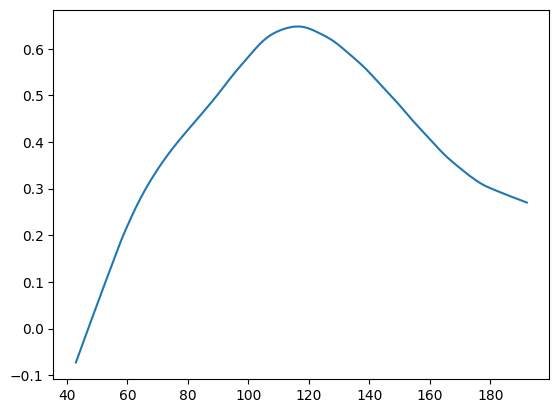

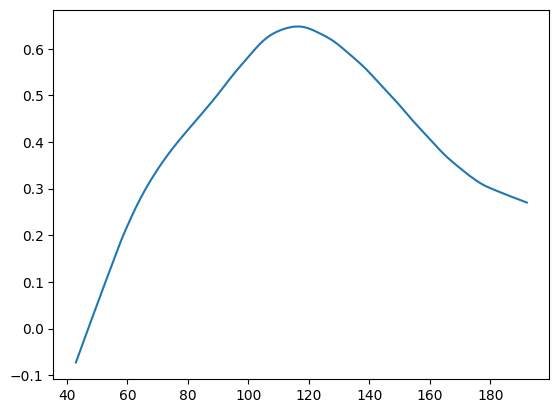

In [23]:
with open('hdvi.pickle', 'rb') as handle:
    NDVI = pickle.load(handle)
print(NDVI)
NDVI[30].plot()

# Procediamo con l'addestramento di NeuralProphet

In [80]:
# Costruiamo il dataframe per l'addestramento
# Devo ricostruire le date

scostamento = 120

rangeForNewDate = range(43,193)
rangeForNewDate2 = range(43,193-scostamento) # Pixel di prova per fare predizione


days = []
days2 = []
zeroDay = datetime.datetime.strptime("2017-01-01","%Y-%m-%d")

for a in rangeForNewDate:
    days.append((zeroDay + datetime.timedelta(days=a)))
serie = NDVI[40].data_matrix.flatten()

for a in rangeForNewDate2:
    days2.append((zeroDay + datetime.timedelta(days=a)))
serie2 = NDVI[120].data_matrix.flatten()[:-(scostamento)]


d = {'ds': days, 'y': serie}
data = pd.DataFrame(data=d)
d2 = {'ds': days2, 'y': serie2}
data2 = pd.DataFrame(data=d2)
print(data2.shape)
data.head(5)

(30, 2)


,ds,y
0,2017-02-13,-0.072685
1,2017-02-14,-0.054671
2,2017-02-15,-0.036719
3,2017-02-16,-0.018831
4,2017-02-17,-0.001009


# Eseguiamo l'addestramento

In [25]:
m = NeuralProphet()
model = m.fit(data, freq='D', epochs=1000)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (10) is too small than the required number for the learning rate finder (209). The results might not be optimal.


Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

# Facciamo la previsione

In [81]:
future = m.make_future_dataframe(data2, periods=scostamento)
forecast = m.predict(future)
forecast.head(5)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.167% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.167% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 10it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_weekly
0,2017-03-15,None,0.368555,0.368198,0.000357
1,2017-03-16,None,0.377242,0.377575,-0.000333
2,2017-03-17,None,0.386892,0.386951,-0.000060
3,2017-03-18,None,0.395068,0.395259,-0.000191
4,2017-03-19,None,0.402368,0.402458,-0.000090


# Stampa della previsione

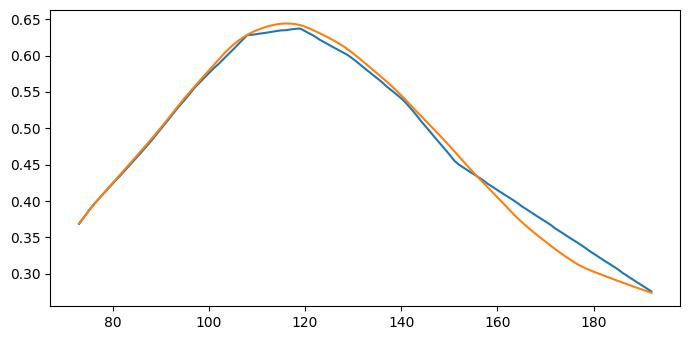

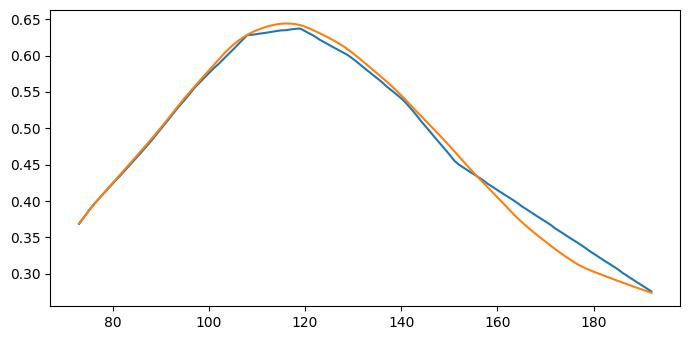

In [82]:
#plot1 = m.plot(forecast)
#print(forecast)
#NDVI[42].plot()
#print(NDVI[42].data_matrix.flatten()[70:].shape)
compare = skfda.FDataGrid(
    data_matrix=[forecast['yhat1'],NDVI[42].data_matrix.flatten()[150-scostamento:]],
    grid_points=range(193-scostamento,193),
)
compare.plot()

# Addestramento di GRU e LSTM

In [28]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from numpy import genfromtxt
from pandas_datareader import data as pdr
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import mannwhitneyu

# Definizione del modello GRU

In [29]:
def GRU_Model(output_window):
  model = Sequential()
  model.add(GRU(150, return_sequences=False, input_shape=data_GRU.shape))
  model.add(Dense(output_window))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  return model

# Definizione del modello LSTM

In [30]:
def LSTM_Model(output_window):
  model = Sequential()
  model.add(LSTM(150, return_sequences=False, input_shape=(NDVI[40].shape,1)))
  model.add(Dense(output_window))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  return model

In [31]:
f = 365

'''d_GRU = {'ds': np.arange(43,193), 'y': serie}
data_GRU = pd.DataFrame(data=d_GRU)


Input = tensorflow.convert_to_tensor(serie)
print(Input)
Input2 = tensorflow.convert_to_tensor(np.arange(43,193))
lstm_model = LSTM_Model(60)
gru_model = GRU_Model(60)
epochs = 200 '''

"d_GRU = {'ds': np.arange(43,193), 'y': serie}\ndata_GRU = pd.DataFrame(data=d_GRU)\n\n\nInput = tensorflow.convert_to_tensor(serie)\nprint(Input)\nInput2 = tensorflow.convert_to_tensor(np.arange(43,193))\nlstm_model = LSTM_Model(60)\ngru_model = GRU_Model(60)\nepochs = 200 "

In [32]:
# Train LSTM model
#lstm_trained = lstm_model.fit(np.array(Input),np.array(Input2), epochs=epochs)
# Train GRU model
#gru_trained = gru_model.fit(data_GRU.to_numpy(), epochs=epochs)